In [1]:
# Initial Imports:

import pandas as pd
from pathlib import Path
import pandas_datareader.data as reader
import datetime as dt
import statsmodels.api as sm
import getFamaFrenchFactors as gff

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# For visualizations:
import seaborn as sns

# PART I: DATA CAPTURE AND ORGANIZATION

## NOTE: Momentum factor is optional in this code

Because our momentum factor was insignificant across multiple time periods (multiple timeframes since 2014),
we have omitted momentum here with hash marks.

In [2]:
end = dt.date(2019, 12, 31)
start = dt.date(2018, 1, 1)
ticker = ["BTC-USD"]

In [3]:
# Get BTC closing prices

btc_dreturns = reader.get_data_yahoo(ticker, start, end)["Close"]
display(btc_dreturns.head())
btc_dreturns.tail()

Symbols,BTC-USD
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


Symbols,BTC-USD
Date,
2019-12-28,7317.990234
2019-12-29,7422.652832
2019-12-30,7292.995117
2019-12-31,7193.599121
2020-01-01,7200.174316


In [4]:
# Get daily returns of BTC

btc_dreturns = btc_dreturns.pct_change().dropna() #convert to daily returns and drop NaN values
display(btc_dreturns.head())
btc_dreturns.tail()

Symbols,BTC-USD
Date,
2018-01-02,0.097011
2018-01-03,0.014611
2018-01-04,0.026196
2018-01-05,0.117333
2018-01-06,0.005594


Symbols,BTC-USD
Date,
2019-12-28,0.003827
2019-12-29,0.014302
2019-12-30,-0.017468
2019-12-31,-0.013629
2020-01-01,0.000914


In [5]:
# Get daily factor data  

ff3_daily = reader.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start, end)[0]  
ff3_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-01-02,0.85,0.35,-0.23,0.005
2018-01-03,0.59,-0.38,-0.18,0.005
2018-01-04,0.42,-0.27,0.23,0.005
2018-01-05,0.66,-0.35,-0.25,0.005
2018-01-08,0.19,-0.15,0.04,0.005


In [6]:
# Divide select columns by 100 (because inputted Mkt-RF, SMB, and HML columns are in percentages while RF column is not).

ff3_daily[["Mkt-RF", "SMB", "HML"]] = ff3_daily[["Mkt-RF", "SMB", "HML"]]/100 
ff3_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-01-02,0.0085,0.0035,-0.0023,0.005
2018-01-03,0.0059,-0.0038,-0.0018,0.005
2018-01-04,0.0042,-0.0027,0.0023,0.005
2018-01-05,0.0066,-0.0035,-0.0025,0.005
2018-01-08,0.0019,-0.0015,0.0004,0.005


In [7]:
# Read in Momentum factor data from CSV included in Resources folder of this repo.
# Note: as per this notebook, using Momentum as a factor can be turned on and off with hashes in applicable cells.
# This notebook is set up to use it or not use it, depending on user preference.
# Across a number of time periods, we have not found it to be a significant factor with BTC.

momentum_factor = pd.read_csv(
    Path("./Resources/F-F_Momentum_Factor_daily.csv"),
    header=None
)

momentum_factor

,0,1
0,19261103,0.56
1,19261104,-0.50
2,19261105,1.17
3,19261106,-0.03
4,19261108,-0.01
...,...,...
25106,20220329,-1.98
25107,20220330,1.03
25108,20220331,0.40
25109,NaN,NaN


In [8]:
# Asssign column names

momentum_factor.columns = ["Date", "Mom"]
momentum_factor.columns

Index(['Date', 'Mom'], dtype='object')

In [9]:
# Choose select dates 

momentum_factor = momentum_factor.loc[
    (momentum_factor["Date"] >= "20180101")
    &(momentum_factor["Date"] <= "20191231")
]

In [10]:
display(momentum_factor.head())
momentum_factor.tail()

,Date,Mom
24039,20180102,-0.64
24040,20180103,0.22
24041,20180104,-0.20
24042,20180105,0.60
24043,20180108,0.15


,Date,Mom
24537,20191224,0.16
24538,20191226,0.30
24539,20191227,0.37
24540,20191230,0.05
24541,20191231,-0.46


In [11]:
# Set index

momentum_factor.set_index("Date")

,Mom
Date,
20180102,-0.64
20180103,0.22
20180104,-0.20
20180105,0.60
20180108,0.15
...,...
20191224,0.16
20191226,0.30
20191227,0.37


In [12]:
# Drop NaNs

momentum_factor = momentum_factor.dropna()
momentum_factor.shape

(503, 2)

In [13]:
# Divide by 100 (because inputted Mom column is in percentages).

momentum_factor["Mom"] = momentum_factor["Mom"]/100  
momentum_factor.head()

,Date,Mom
24039,20180102,-0.0064
24040,20180103,0.0022
24041,20180104,-0.0020
24042,20180105,0.0060
24043,20180108,0.0015


In [14]:
# Set index to the index of ff3_daily dataframe.

momentum_factor.index = ff3_daily.index

In [15]:
# Drop extra column

momentum_factor.drop(columns="Date", inplace=True)
momentum_factor

,Mom
Date,
2018-01-02,-0.0064
2018-01-03,0.0022
2018-01-04,-0.0020
2018-01-05,0.0060
2018-01-08,0.0015
...,...
2019-12-24,0.0016
2019-12-26,0.0030
2019-12-27,0.0037


In [16]:
# Merging FF3 daily facotr data with BTC daily return data into one dataframe

regress_data = ff3_daily.merge(btc_dreturns, on="Date")  
display(regress_data.head())
regress_data.tail()

,Mkt-RF,SMB,HML,RF,BTC-USD
Date,,,,,
2018-01-02,0.0085,0.0035,-0.0023,0.005,0.097011
2018-01-03,0.0059,-0.0038,-0.0018,0.005,0.014611
2018-01-04,0.0042,-0.0027,0.0023,0.005,0.026196
2018-01-05,0.0066,-0.0035,-0.0025,0.005,0.117333
2018-01-08,0.0019,-0.0015,0.0004,0.005,-0.079350


,Mkt-RF,SMB,HML,RF,BTC-USD
Date,,,,,
2019-12-24,0.0001,0.0039,-0.0001,0.007,-0.004499
2019-12-26,0.0048,-0.0054,0.0000,0.007,-0.004974
2019-12-27,-0.0010,-0.0054,-0.0008,0.007,0.007062
2019-12-30,-0.0057,0.0019,0.0056,0.007,-0.017468
2019-12-31,0.0028,0.0000,0.0010,0.007,-0.013629


In [ ]:
# Merging combined FF3 daily factor and BTC daily returns data with Momentum daily factor data

#regress_data = data.merge(momentum_factor, on="Date")  
#regress_data = regress_data[["Mkt-RF", "SMB", "HML", "Mom", "RF", "BTC-USD"]] #ordering columns
#display(regress_data.head())
#regress_data.tail()

In [17]:
# Subtracting risk-free return rate from BTC's daily returns and creating a new column to store the result

regress_data["BTC-RF"] = regress_data["BTC-USD"] - regress_data["RF"]
regress_data.head()

,Mkt-RF,SMB,HML,RF,BTC-USD,BTC-RF
Date,,,,,,
2018-01-02,0.0085,0.0035,-0.0023,0.005,0.097011,0.092011
2018-01-03,0.0059,-0.0038,-0.0018,0.005,0.014611,0.009611
2018-01-04,0.0042,-0.0027,0.0023,0.005,0.026196,0.021196
2018-01-05,0.0066,-0.0035,-0.0025,0.005,0.117333,0.112333
2018-01-08,0.0019,-0.0015,0.0004,0.005,-0.079350,-0.084350


<AxesSubplot:xlabel='Mkt-RF', ylabel='BTC-RF'>

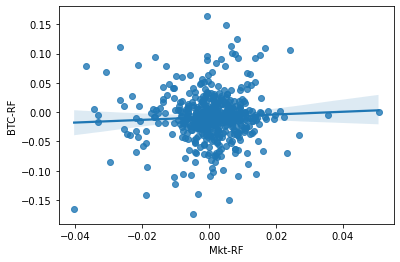

In [18]:
# Checking relationships between two variables graphically using seaborn regplot. Scatter plot shows excess returns on the 
# market versus excess returns on BTC.

sns.regplot(x="Mkt-RF", y="BTC-RF", data=regress_data) 

In [19]:
X = regress_data[["Mkt-RF", "SMB", "HML"]]  #the independent variables     
# X = regress_data[["Mkt-RF", "SMB", "HML", "Mom"]] #the independent variables four 4 factors
y = regress_data["BTC-RF"]  #the dependent variable

X1 = sm.add_constant(X) #defining the constant
model = sm.OLS(y, X1)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BTC-RF   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5827
Date:                Tue, 10 May 2022   Prob (F-statistic):              0.627
Time:                        17:51:05   Log-Likelihood:                 889.10
No. Observations:                 503   AIC:                            -1770.
Df Residuals:                     499   BIC:                            -1753.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0085      0.002     -4.597      0.000      -0.012      -0.005
Mkt-RF         0.2518      0.197      1.275      0.203      -0.136       0.640
SMB           -0.1580      0.369     -0.428      0.669      -0.883       0.567
HML            0.0986      0.327      0.302      0.763      -0.544       0.741
==============================================================================
Omnibus:                       35.806   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.669
Skew:                           0.124   Prob(JB):                     2.10e-30
Kurtosis:                       5.542   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
#Note: The Prob (F-statistic) depicts probability of the null hypothesis being true, and can be thought of as the p-value for the 
#regression as a whole. Our F-statistic significantly above 0 implies that overall the regressions were insignificant.

In [21]:
# Saving the coefficients, which tell us how much exposure BTC has to the market, size, value, and momentum. 
# Note on Fama French Factors: There is some systematic risk due to size, value (book equity to market equity), and momementum of 
# stocks. Stock risks are multidimensional! 

intercept, beta_m, beta_s, beta_v = results.params  
#intercept, beta_m, beta_s, beta_v, beta_mom = results.params   #for 4 factors
print(beta_m, beta_s, beta_v)
# print(beta_m, beta_s, beta_v, beta_mom)   #for 4 factors 

0.2517795185118787 -0.15802220698856306 0.09860289283873555


In [22]:
# Getting average risk free rate

risk_free = regress_data["RF"].mean()
risk_free

0.007773359840954243

In [23]:
# Calculating expected excess return of the market (the market risk premium). Note, all is based on daily returns! So as calculated here, 
# the average daily return of the S&P500 (in excess of risk-free rate) during this period is .0975%.
# Calculating expected excess return due to size (the size risk premium).
# Calculating expected excess return due to value (the value risk premium).
# Calculating expected excess return due to momentum (the momentum risk premium).

market_premium = regress_data["Mkt-RF"].mean()
size_premium = regress_data["SMB"].mean()
value_premium = regress_data["HML"].mean()
#momentum_premium = regress_data["Mom"].mean()  #use for 4 factors

print(market_premium, size_premium, value_premium)  #monthly premiums, shows how market, size, value, momentum yield premiums
#print(market_premium, size_premium, value_premium, momentum_premium) #use for 4 factors

0.0003940357852882703 -0.00015427435387673966 -0.0003823061630218686


In [24]:
#Compute expected return of BTC 

btc_exp_return = intercept + risk_free + (beta_m * market_premium) + (beta_s * size_premium) + (beta_v * value_premium) 
#btc_exp_return = risk_free + (beta_m * market_premium) + (beta_s * size_premium) + (beta_v * value_premium) + (beta_mom * momentum_premium) #use for 4 factors

btc_exp_yr_return = btc_exp_return * 252

print(f"Using the Fama French Four Factor model, the expected daily return of Bitcoin is: %{btc_exp_return*100}.")
print(f"Using the Fama French Four Factor model, the expected annual return of Bitcoin is: %{btc_exp_yr_return*100}.")

Using the Fama French Four Factor model, the expected daily return of Bitcoin is: %-0.06714601407403235.
Using the Fama French Four Factor model, the expected annual return of Bitcoin is: %-16.92079554665615.


# PART III: TRAINING AND TESTING THE DATA

In [25]:
# Split data into training data (80%) and test data (20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [26]:
# Instantiate

model = LinearRegression()

In [27]:
# Fit

model.fit(X_train, y_train)

LinearRegression()

In [28]:
# Predict

y_pred = model.predict(X_test)

In [29]:
# Model evaluation

score = r2_score(y_test, y_pred)
percent_score = round((score * 100), 2)

print(f"Your model will correctly predict the price of Bitcoin {percent_score}% of the time.")
print(f"Or in other words, {percent_score}% of BTC's excess return on the market is explained by these factors.")

Your model will correctly predict the price of Bitcoin -7.99% of the time.
Or in other words, -7.99% of BTC's excess return on the market is explained by these factors.
